## A simple model for demand and supply of publicly-provided services in a city

### Demand modelling

In [1]:
from enum import Enum
import os.path

import numpy as np
import pandas as pd
import geopandas as gpd
import geopy, geopy.distance
import shapely
from sklearn import gaussian_process

from matplotlib import pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize']= (20,14)

In [2]:
## TODO: find way to put this into some global settings
import os
import sys
nb_dir = os.path.dirname(os.getcwd())
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg

In [3]:
from src.models.city_items import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [4]:
from src.models.core import MappedPositionsFrame, DemandFrame

In [5]:
gaussKern = gaussian_process.kernels.RBF
get_random_pos = lambda n: list(map(geopy.Point, list(zip(np.round(np.random.uniform(45.40, 45.50, n), 5), 
                                np.round(np.random.uniform(9.1, 9.3, n), 5)))))
make_shapely_point = lambda geoPoint: shapely.geometry.Point((geoPoint.longitude, geoPoint.latitude))

In [ ]:
class DemandFrame(pd.DataFrame):
    '''A class to store demand units in row and 
    make them available for aggregation'''
    
    def __init__(self, dfIn, bDuplicatesCheck=True):
        assert isinstance(dfIn, pd.DataFrame), 'Input DataFrame expected'
        self.__dict__.update(dfIn.copy().__dict__)
        
        # prepare the AgeGroups cardinalities
        groupsCol = 'ageGroup'
        peopleBySampleAge = common_cfg.fill_sample_ages_in_cpa_columns(self)
        dataByGroup = peopleBySampleAge.rename(AgeGroup.find_AgeGroup, axis='columns').T
        dataByGroup.index.name = groupsCol # index is now given by AgeGroup items
        dataByGroup = dataByGroup.reset_index() # extract to convert to categorical and groupby
        dataByGroup[groupsCol] = dataByGroup[groupsCol].astype('category')
        agesBySection = dataByGroup.groupby(groupsCol).sum().T
        #self['Ages'] = pd.Series(agesBySection.T.to_dict()) # assign dict to each section
        self['PeopleTot'] = agesBySection.sum(axis=1)
        # report all ages
        for col in AgeGroup.all():
            self[col] = agesBySection.get(col, np.zeros_like(self.iloc[:,0]))
        
        # assign centroid as position
        geopyValues = self['geometry'].apply(
            lambda pos: geopy.Point(pos.centroid.y, pos.centroid.x))
        self[common_cfg.positionsCol] = geopyValues
        
        if bDuplicatesCheck:
            # check no location is repeated - takes a while
            assert not any(self[common_cfg.positionsCol].duplicated()), 'Repeated position found'
            
            
    @property
    def mappedPositions(self):
        return MappedPositionsFrame(positions=self[common_cfg.positionsCol].tolist(),
            idQuartiere=self[common_cfg.IdQuartiereColName].tolist())
    
    @property
    def agesFrame(self):
        ageMIndex = [self[common_cfg.IdQuartiereColName],
                         self[common_cfg.positionsCol].apply(tuple)]
        return self[AgeGroup.all()].set_index(ageMIndex)
    
    def get_age_sample(self, ageGroup=None, nSample=1000):
        
        if ageGroup is not None:
            coord, nRep = self.mappedPositions.align(self.agesFrame[ageGroup], axis=0)
        else:
            coord, nRep = self.mappedPositions.align(self.agesFrame.sum(axis=1), axis=0)
        idx = np.repeat(range(coord.shape[0]), nRep)
        coord = coord[common_cfg.coordColNames].iloc[idx]
        sample = coord.sample(int(nSample)).as_matrix()
        return sample[:,0], sample[:,1]
    
    @staticmethod
    def create_from_istat_cpa(cityName):
        '''Constructor caller for DemandFrame'''
        assert cityName in common_cfg.cityList, \
            'Unrecognised city name "%s"' % cityName
        frame = DemandFrame(common_cfg.get_istat_cpa_data(cityName),
                          bDuplicatesCheck=False)
        return frame

In [6]:
bb = DemandFrame.create_from_istat_cpa('Milano')

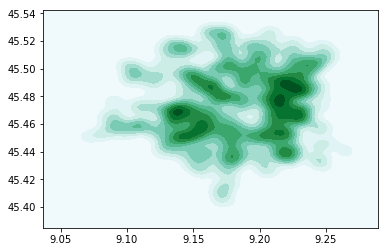

In [7]:
sns.kdeplot(*bb.get_age_sample(None,3e4),shade=True, shade_lowest=True)

In [ ]:
from src.models.process_tools import ValuesPlotter
from src.models.services_supply import ServiceValues
ptt = ValuesPlotter(ServiceValues(bb.mappedPositions))
ptt.plot_locations()